# V-JEPA Segmentation — Colab Demo



In Colab, choose **Runtime → Change runtime type → GPU** for speed.


In [1]:
import os, sys, subprocess, shutil, shlex
from pathlib import Path
import urllib.request


In [ ]:

CKPTS = Path("ckpts")
CKPTS.mkdir(exist_ok=True)

vjepa_pt  = CKPTS / "vjepa2_vitl_256.pt"
head_pt   = CKPTS / "head_linear_fpn_best.pt"

print("Backbone exists?", vjepa_pt.exists())
print("Head exists?", head_pt.exists())


Backbone exists? True
Head exists? True


In [3]:

# 1) Jump to the Git repo root (fallback: climb until we find pyproject.toml/.git)
try:
    ROOT = subprocess.check_output(["git", "rev-parse", "--show-toplevel"], text=True).strip()
except Exception:
    # fallback: walk up parents until we see a marker file/folder
    here = Path.cwd()
    for p in [here, *here.parents]:
        if (p / ".git").exists() or (p / "pyproject.toml").exists():
            ROOT = str(p); break
    else:
        ROOT = str(here)  # last resort
os.chdir(ROOT)
print("Project root:", Path.cwd())

# 2) Paths now relative to the repo root
CKPTS = Path("ckpts")
CKPTS.mkdir(exist_ok=True)
vjepa_pt = CKPTS / "vjepa2_vitl_256.pt"
print("Backbone path:", vjepa_pt, "exists:", vjepa_pt.exists())

# (optional) show size if present
if vjepa_pt.exists():
    print("Backbone size:", vjepa_pt.stat().st_size, "bytes")


Project root: /Users/pouyaabbasi/Documents/Projects/vjepa_segmentation
Backbone path: ckpts/vjepa2_vitl_256.pt exists: True
Backbone size: 5127726842 bytes


In [4]:

REPO_URL = "https://github.com/PouyaRepos/vjepa_segmentation.git"  
BRANCH   = "feature/vjepa2-hub"  # branch with V-JEPA 2.0 support
HEAD_URL = "https://github.com/PouyaRepos/vjepa_segmentation/releases#:~:text=Update%20README.md-,Assets,-3"

# sample inputs
IMAGE_PATH = "samples/person.jpg"
VIDEO_PATH = "samples/clip.mp4"

print("REPO_URL:", REPO_URL)
print("BRANCH:", BRANCH)
print("HEAD_URL set:", bool(HEAD_URL))
print("IMAGE_PATH:", IMAGE_PATH)
print("VIDEO_PATH:", VIDEO_PATH)

REPO_URL: https://github.com/PouyaRepos/vjepa_segmentation.git
BRANCH: feature/vjepa2-hub
HEAD_URL set: True
IMAGE_PATH: samples/person.jpg
VIDEO_PATH: samples/clip.mp4


In [9]:
!nvidia-smi -L || echo "No GPU (that's ok, but slower)"
!python --version
!pip -q install -U pip
# core libs
!pip -q install timm einops opencv-python

zsh:1: command not found: nvidia-smi
No GPU (that's ok, but slower)
Python 3.9.21


In [ ]:
from IPython import get_ipython
REPO_URL = "https://github.com/PouyaRepos/vjepa_segmentation.git"  
BRANCH   = "feature/vjepa2-hub"  # branch with V-JEPA 2.0 support


def find_repo_root():
    p = Path.cwd()
    for q in [p, *p.parents]:
        if (q / "pyproject.toml").exists() or (q / ".git").exists():
            return q
    return None

root = find_repo_root()

if root:
    os.chdir(root)
    print("Using existing repo root:", Path.cwd())
else:
    # Not inside the repo (e.g., Colab) → clone once
    if not Path("vjepa_segmentation").exists():
        print("Cloning repo…")
        # ! is fine in Jupyter
        get_ipython().system(f'git clone -b "{BRANCH}" "{REPO_URL}" vjepa_segmentation')
    os.chdir("vjepa_segmentation")
    print("Entered cloned repo root:", Path.cwd())

# Ensure dirs
Path("ckpts").mkdir(exist_ok=True)
Path("media").mkdir(exist_ok=True)

# Ensure package is installed (editable) if not already importable
try:
    import vjepa_seg  # noqa
    print("Package import OK")
except Exception:
    print("Installing package…")
    get_ipython().system('pip -q install -r requirements.txt || true')
    get_ipython().system('pip -q install -e .')
    import importlib; importlib.invalidate_caches()
    import vjepa_seg  # noqa
    print("Installed.")


Using existing repo root: /Users/pouyaabbasi/Documents/Projects/vjepa_segmentation
Package import OK


In [7]:
import urllib.request

# Backbone (V-JEPA2 ViT-L/16). Official link from Meta's README.
vjepa_pt = "ckpts/vjepa2_vitl_256.pt"
if not os.path.exists(vjepa_pt):
    url = "https://dl.fbaipublicfiles.com/vjepa2/vitl.pt"
    print("Downloading backbone ->", vjepa_pt)
    urllib.request.urlretrieve(url, vjepa_pt)
else:
    print("Found backbone:", vjepa_pt)

# Head checkpoint 
head_pt = "ckpts/head_linear_fpn_best.pt"
if os.path.exists(head_pt):
    print("Found head:", head_pt)
elif HEAD_URL:
    print("Downloading head ->", head_pt)
    urllib.request.urlretrieve(HEAD_URL, head_pt)
else:
    print("No head checkpoint found and HEAD_URL not set.\n"
          "Upload ckpts/head_linear_fpn_best.pt via the Colab file browser if you want real inference.\n"
          "Otherwise, the notebook will run a dummy smoke test.")

Found backbone: ckpts/vjepa2_vitl_256.pt
Found head: ckpts/head_linear_fpn_best.pt


YAML Content:
 data:
  root: /Users/pouyaabbasi/Documents/Projects/datasets/cihp
  num_classes: 6
  img_size: [256, 256]
  aug:
    flip: true
    color_jitter: 0.0

model:
  backbone_out_dim: 1024
  fpn_dim: 128

train:
  epochs: 2
  batch_size: 1
  lr: 0.0003
  weight_decay: 0.0001

eval:
  metric: miou

infer:
  ema_logits_alpha: 0.6
Using device: mps


Using cache found in /Users/pouyaabbasi/.cache/torch/hub/facebookresearch_vjepa2_main
/Users/pouyaabbasi/Documents/Projects/vjepa_segmentation/.venv/lib/python3.9/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


[VJEPA] Overriding num_frames 64 -> 1 to avoid large attention buffers.
[VJEPA] 292 model keys missing in checkpoint (ok if heads differ).
[load] head weights: ckpts/head_linear_fpn_best.pt


/opt/homebrew/Cellar/python@3.9/3.9.21/Frameworks/Python.framework/Versions/3.9/lib/python3.9/contextlib.py:87: FutureWarning: `torch.backends.cuda.sdp_kernel()` is deprecated. In the future, this context manager will be removed. Please see `torch.nn.attention.sdpa_kernel()` for the new context manager, with updated signature.
  self.gen = func(*args, **kwds)


labels present: [2, 4, 5]
wrote media/demo_image_overlay.jpg


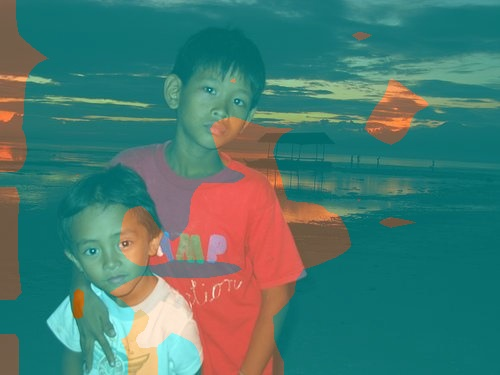

In [13]:
%%capture --no-display

def run(cmd_list):
    print("RUN:", " ".join(shlex.quote(c) for c in cmd_list))
    return subprocess.run(cmd_list, check=False)

img_exists = os.path.exists(IMAGE_PATH)
have_head = os.path.exists("ckpts/head_linear_fpn_best.pt")
have_back = os.path.exists("ckpts/vjepa2_vitl_256.pt")

if not img_exists:
    print("Image not found:", IMAGE_PATH)
else:
    os.makedirs("media", exist_ok=True)
    if have_head and have_back:
        cmd = [
            "python","-m","vjepa_seg.inference",
            "--config","configs/cihp_linear_fpn.yaml",
            "--image", IMAGE_PATH,
            "--out","media/demo_image_overlay.jpg",
            "--ckpt","ckpts/head_linear_fpn_best.pt",
            "--vjepa_ckpt","ckpts/vjepa2_vitl_256.pt",
        ]
    else:
        cmd = [
            "python","-m","vjepa_seg.inference",
            "--config","configs/cihp_linear_fpn.yaml",
            "--image", IMAGE_PATH,
            "--out","media/smoke_out.png",
            "--ckpt","",
            "--dummy_backbone","1",
        ]
    run(cmd)

from IPython.display import Image, display
if os.path.exists("media/demo_image_overlay.jpg"):
    display(Image(filename="media/demo_image_overlay.jpg"))
elif os.path.exists("media/smoke_out.png"):
    display(Image(filename="media/smoke_out.png"))

In [8]:
from IPython.display import HTML, display

vid_exists = os.path.exists(VIDEO_PATH)
have_head = os.path.exists("ckpts/head_linear_fpn_best.pt")
have_back = os.path.exists("ckpts/vjepa2_vitl_256.pt")

def run(cmd_list):
    print("RUN:", " ".join(shlex.quote(c) for c in cmd_list))
    return subprocess.run(cmd_list, check=False)

if not vid_exists:
    print("Video not found:", VIDEO_PATH)
else:
    if have_head and have_back:
        cmd = [
            "python","-m","vjepa_seg.inference",
            "--config","configs/cihp_linear_fpn.yaml",
            "--video", VIDEO_PATH,
            "--out","out.mp4",
            "--ema","0.6",
            "--ckpt","ckpts/head_linear_fpn_best.pt",
            "--vjepa_ckpt","ckpts/vjepa2_vitl_256.pt",
        ]
    else:
        cmd = [
            "python","-m","vjepa_seg.inference",
            "--config","configs/cihp_linear_fpn.yaml",
            "--video", VIDEO_PATH,
            "--out","out.mp4",
            "--ema","0.0",
            "--ckpt","",
            "--dummy_backbone","1",
        ]
    run(cmd)
    
    # Small GIF preview
    if os.path.exists("out.mp4"):
        !ffmpeg -y -i out.mp4 -vf "fps=15,scale=512:-1:flags=lanczos" -t 4 media/demo_video.gif
        if os.path.exists("media/demo_video.gif"):
            display(HTML('<img src="media/demo_video.gif" />'))

RUN: python -m vjepa_seg.inference --config configs/cihp_linear_fpn.yaml --video samples/clip.mp4 --out out.mp4 --ema 0.6 --ckpt ckpts/head_linear_fpn_best.pt --vjepa_ckpt ckpts/vjepa2_vitl_256.pt
YAML Content:
 data:
  root: /Users/pouyaabbasi/Documents/Projects/datasets/cihp
  num_classes: 6
  img_size: [256, 256]
  aug:
    flip: true
    color_jitter: 0.0

model:
  backbone_out_dim: 1024
  fpn_dim: 128

train:
  epochs: 2
  batch_size: 1
  lr: 0.0003
  weight_decay: 0.0001

eval:
  metric: miou

infer:
  ema_logits_alpha: 0.6
Using device: mps


Using cache found in /Users/pouyaabbasi/.cache/torch/hub/facebookresearch_vjepa2_main
/Users/pouyaabbasi/Documents/Projects/vjepa_segmentation/.venv/lib/python3.9/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


[VJEPA] Overriding num_frames 64 -> 1 to avoid large attention buffers.
[VJEPA] 292 model keys missing in checkpoint (ok if heads differ).
[load] head weights: ckpts/head_linear_fpn_best.pt


/opt/homebrew/Cellar/python@3.9/3.9.21/Frameworks/Python.framework/Versions/3.9/lib/python3.9/contextlib.py:87: FutureWarning: `torch.backends.cuda.sdp_kernel()` is deprecated. In the future, this context manager will be removed. Please see `torch.nn.attention.sdpa_kernel()` for the new context manager, with updated signature.
  self.gen = func(*args, **kwds)


[frame 0] labels: [0, 1, 2]
[frame 1] labels: [0, 1, 2]
[frame 2] labels: [0, 1, 2]
[frame 3] labels: [0, 1, 2]
[frame 4] labels: [0, 1, 2]
wrote out.mp4
ffmpeg version 7.1.1 Copyright (c) 2000-2025 the FFmpeg developers
  built with Apple clang version 17.0.0 (clang-1700.0.13.3)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/7.1.1_5 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfo